<a href="https://colab.research.google.com/github/Pandu98-pkh/DeepLearning/blob/main/01.%20Week%201/Notebook%20Assigment/Classification%20Income.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [95]:
!pip install torch torchvision
!pip install tensorflow
!pip install numpy pandas matplotlib scikit-learn
!pip install category_encoders

In [96]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split # untuk membagi data menjadi data latih dan data uji
from sklearn.preprocessing import LabelEncoder, MinMaxScaler # untuk mengubah label kelas menjadi angka
from sklearn.feature_selection import SelectKBest, f_classif
from category_encoders import TargetEncoder
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, confusion_matrix
import math

In [97]:
url = "https://raw.githubusercontent.com/Pandu98-pkh/DeepLearning/refs/heads/main/01.%20Week%201/Dataset/income.csv"

try:
  df = pd.read_csv(url).dropna()
except Exception as e:
  print(f"Error loading dataset: {e}")

In [98]:
df.sample(10) # menampilkan 10 sample data secara acak

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
5315,32,Private,183356,HS-grad,9,Never-married,Craft-repair,Own-child,White,Male,0,0,40,United-States,<=50K
29859,52,Local-gov,298035,Masters,14,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,40,United-States,<=50K
9257,19,Without-pay,344858,HS-grad,9,Never-married,Farming-fishing,Own-child,White,Male,0,0,20,United-States,<=50K
5968,64,Self-emp-inc,165667,Doctorate,16,Married-civ-spouse,Prof-specialty,Husband,White,Male,7688,0,60,Canada,>50K
24366,26,Private,211424,Some-college,10,Married-civ-spouse,Handlers-cleaners,Husband,White,Male,0,0,40,United-States,>50K
35208,42,Private,347653,Bachelors,13,Divorced,Other-service,Unmarried,White,Male,0,0,60,United-States,<=50K.
28288,36,Private,223433,Masters,14,Married-civ-spouse,Sales,Husband,White,Male,7688,0,50,United-States,>50K
9887,26,Private,127202,HS-grad,9,Divorced,Machine-op-inspct,Not-in-family,White,Male,0,0,40,United-States,<=50K
20658,36,Private,218948,9th,5,Separated,Other-service,Unmarried,Black,Female,0,0,40,?,<=50K
16713,43,Private,148998,HS-grad,9,Divorced,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K


In [99]:
df.describe() # menampilkan statistik data

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,47621.000000,4.762100e+04,47621.000000,47621.000000,47621.000000,47621.000000
mean,38.640684,1.897271e+05,10.090821,1091.137649,87.853489,40.600050
std,13.558961,1.055695e+05,2.568320,7487.228336,404.010612,12.260345
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.175840e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.782820e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.377200e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.490400e+06,16.000000,99999.000000,4356.000000,99.000000


In [100]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 47621 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             47621 non-null  int64 
 1   workclass       47621 non-null  object
 2   fnlwgt          47621 non-null  int64 
 3   education       47621 non-null  object
 4   education-num   47621 non-null  int64 
 5   marital-status  47621 non-null  object
 6   occupation      47621 non-null  object
 7   relationship    47621 non-null  object
 8   race            47621 non-null  object
 9   sex             47621 non-null  object
 10  capital-gain    47621 non-null  int64 
 11  capital-loss    47621 non-null  int64 
 12  hours-per-week  47621 non-null  int64 
 13  native-country  47621 non-null  object
 14  income          47621 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.8+ MB


In [101]:
# Menghapus spasi tambahan dari kolom kategori jika ada
db = df.apply(lambda x: x.str.strip(' .') if x.dtype == "object" else x)
# Mengubah target menjadi biner (0 = <=50K, 1 = >50K)
db['income'] = LabelEncoder().fit_transform(db['income'])
# Memisahkan fitur numerik dan kategorikal
num_cols = db.drop(columns=['income']).select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = db.select_dtypes(include=['object']).columns.tolist()

# Mengonversi variabel kategori menggunakan One-Hot Encoding
encoder = TargetEncoder()
db_encoded = encoder.fit_transform(db[cat_cols], db['income'])
db = db.drop(columns=cat_cols).join(db_encoded)

# Normalisasi fitur numerik
scaler = MinMaxScaler()
db[num_cols] = scaler.fit_transform(db[num_cols])

# Memisahkan fitur (X) dan target (y)
X = db.drop(columns=['income']).values
y = db['income'].values

print(X, y) # menampilkan data fitur dan label

# Memisahkan data menjadi data latih dan data uji
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


[[0.30136986 0.04413121 0.8        ... 0.25707351 0.30701068 0.24731133]
 [0.45205479 0.04805174 0.8        ... 0.25707351 0.30701068 0.24731133]
 [0.28767123 0.13758131 0.53333333 ... 0.25707351 0.30701068 0.24731133]
 ...
 [0.28767123 0.24537874 0.8        ... 0.25707351 0.30701068 0.24731133]
 [0.36986301 0.04844413 0.8        ... 0.27436075 0.30701068 0.24731133]
 [0.24657534 0.11491866 0.8        ... 0.25707351 0.30701068 0.24731133]] [0 0 0 ... 0 0 1]


In [102]:
# prompt: Mempersiapkan Rumus Evaluasi (Akurasi, Presisi, Recall, F1Squared, AUC, ROC)
# # Fungsinya untuk menghitung metrik evaluasi
# # Metrik evaluasi yang digunakan adalah akurasi, presisi, recall, F1-score, AUC, dan ROC

def evaluate_model(y_true, y_pred, y_prob):
    """
    Evaluates the model's performance using various metrics.

    Args:
        y_true: True labels.
        y_pred: Predicted labels.
        y_prob: Predicted probabilities.

    Returns:
        A dictionary containing the evaluation metrics.
    """

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc_score = roc_auc_score(y_true, y_prob)

    fpr, tpr, thresholds = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)


    # Calculate F1-squared
    f1_squared = f1**2

    evaluation_metrics = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'F1-Squared': f1_squared,
        'AUC': auc_score,
        'ROC_AUC': roc_auc
    }

    return evaluation_metrics


In [123]:
def plot_confusion_matrix(y_true, y_pred, model_name):
    """
    Displays a confusion matrix to evaluate the model, showing percentages.

    Args:
        y_true: True labels.
        y_pred: Predicted labels.
        model_name: Name of the model.
    """
    cm = confusion_matrix(y_true, y_pred)
    cm_percentage = cm.astype('float') / cm.sum() * 100 # Calculate percentages based on total

    plt.figure(figsize=(8, 6))
    ax = sns.heatmap(cm_percentage, annot=True, fmt=".2f", cmap="Blues", # Display percentages with 2 decimal places
                xticklabels=['<=50K', '>50K'], yticklabels=['<=50K', '>50K'])
    plt.title(f'Confusion Matrix for {model_name} (Percentage)') # Update title
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

    # Iterasi setiap teks di dalam heatmap dan tambahkan tanda %
    for t in ax.texts:
        t.set_text(t.get_text() + " %")

    plt.show()

def plot_training_history(history, model_name):
    """
    Displays the training history of the model.

    Args:
        history: Training history object.
        model_name: Name of the model.
    """
    # Assuming history object has 'accuracy' and 'loss' keys for both training and validation
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    # Modified to use the 'loss' column from the history DataFrame
    plt.plot(history['epoch'], history['loss'], label='Training Loss')
    plt.title(f'{model_name} Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Removed the validation accuracy and loss plots as they are not available
    # in the current history DataFrame

    plt.show()


In [104]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [105]:
# prompt: Mengonversi Dataset Menjadi Tipe Tensor PyTorch

# Mengonversi data latih dan data uji menjadi tensor PyTorch
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)  # Reshape y_train_tensor
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)  # Reshape y_test_tensor

# Membuat TensorDataset
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Membuat DataLoader
batch_size = 32  # Contoh ukuran batch
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [111]:
# prompt: Menyusun Model Neural Network Sederhana pytorch

# Define the neural network architecture
class Net(nn.Module):
    def __init__(self, input_size):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x

# Instantiate the model, define loss function, and optimizer
input_size = X_train.shape[1]
model = Net(input_size)

In [112]:
criterion = nn.BCELoss()  # Binary Cross Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=0.005)

In [113]:
# Melatih model
num_epochs = 100 # Jumlah iterasi pelatihan
history = pd.DataFrame() # Menyimpan statistik pelatihan
for epoch in range(num_epochs):
    optimizer.zero_grad() # Mengatur gradien menjadi 0 sebelum melakukan backpropagation
    y_pred = model(X_train_tensor) # Memprediksi data latih
    loss = criterion(y_pred, y_train_tensor) # Menghitung loss
    loss.backward() # Backpropagation
    optimizer.step() # Update bobot
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, loss={loss.item()}')
    # Menyimpan statistik pelatihan untuk menampilkan plot
    history = pd.concat([history, pd.DataFrame({'epoch': [epoch], 'loss': [loss.item()]})], ignore_index=True)

Epoch 0, loss=0.7040116786956787
Epoch 10, loss=0.5769214034080505
Epoch 20, loss=0.5327432155609131
Epoch 30, loss=0.4586855173110962
Epoch 40, loss=0.38438400626182556
Epoch 50, loss=0.3566608428955078
Epoch 60, loss=0.3479020893573761
Epoch 70, loss=0.3396022617816925
Epoch 80, loss=0.3350464999675751
Epoch 90, loss=0.3305125832557678


In [114]:
# Evaluation
y_pred_list = []
y_prob_list = []
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        y_prob_list.extend(outputs.numpy())
        predicted = (outputs > 0.5).float() # Convert probabilities to binary predictions
        y_pred_list.extend(predicted.numpy())

y_pred_list = np.array(y_pred_list).reshape(-1)
y_prob_list = np.array(y_prob_list).reshape(-1)
#Evaluate the model
metrics = evaluate_model(y_test, y_pred_list, y_prob_list)
print(metrics)

{'Accuracy': 0.8453543307086614, 'Precision': 0.7494343891402715, 'Recall': 0.5626326963906582, 'F1-Score': 0.6427358719379093, 'F1-Squared': 0.4131094010757845, 'AUC': 0.9026088591589752, 'ROC_AUC': 0.9026088591589752}


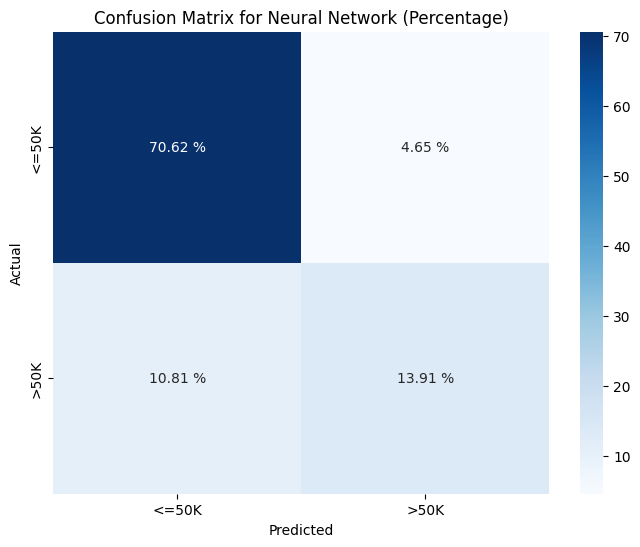

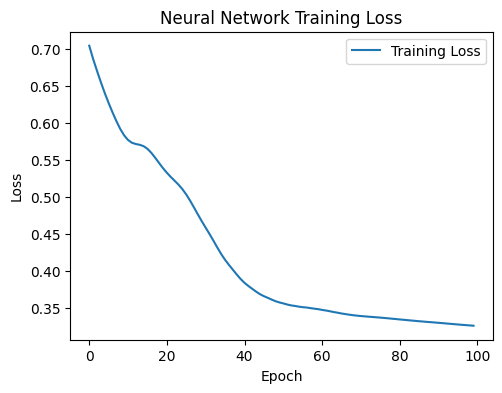

In [124]:
# prompt: Memvisualisasikan Prediksi dari model yang telah dilatih
#  plot_confusion_matrix(y_true, y_pred, model_name):
# def plot_training_history(history, model_name)

plot_confusion_matrix(y_test, y_pred_list, 'Neural Network')
# Assuming 'history' is available from the model training
plot_training_history(history, 'Neural Network')
